# 支持向量机 (SVM）

In [1]:
import numpy as np
from sklearn import metrics
import cvxopt       # 使用cvxopt包求解二次规划
from nnc.plot_tool import *

In [2]:
# 定义核函数
# Linear kernel  线性核
def linear_kernel(X,X_):
    if X.ndim == 1:
        X = X.reshape(1,len(X))
    if X_.ndim == 1:
        X_ = X_.reshape(1,len(X))
    # P,N = X_.shape    # 样本数目,样本维度
    K =  X @ X_.T
    return K

# Polynomial kernel   二次多项式核函数
def polynomial_kernel(X,X_,n=2):
    # 多项式核
    if X.ndim == 1:
        X = X.reshape(1,len(X))
    if X_.ndim == 1:
        X_ = X_.reshape(1,len(X))
    # P,N = X_.shape    # 样本数目,样本维度
    K = (X @ X_.T)**n
    return K

# Gaussian kernel
def gauss_kernel(X,X_,sigma=0.5):
    # Gaussian 核
    if X.ndim == 1:
        X = X.reshape(1,len(X))
    if X_.ndim == 1:
        X_ = X_.reshape(1,len(X))
    # P,N = X_.shape    # 样本数目,样本维度
    K = []
    for x in X:
        K.append(np.exp(-0.5*(np.linalg.norm(X_-x,axis=1)/sigma)**2))
    return np.array(K)  

# Laplace kernel
def laplace_kernel(X,X_,sigma=0.5):
    # Laplace 核
    if X.ndim == 1:
        X = X.reshape(1,len(X))
    if X_.ndim == 1:
        X_ = X_.reshape(1,len(X))
    # P,N = X_.shape    # 样本数目,样本维度
    K = []
    for x in X:
        K.append(np.exp(-np.linalg.norm(X_-x,axis=1)/sigma))
    return np.array(K)  

#输入数据 (加入阈值分量)
def addIntercept(X):   # X.shape = (P,M) 
    return np.hstack((X, np.ones((X.shape[0], 1))))#输出（P,M+1)


In [3]:
# 核SVM
# 求解二次规划（quadprog）
class kernel_svm(object):
    
    def __init__(self,input_size,sample_num,**kwargs):
        super(kernel_svm,self).__init__()
        self.input_size = input_size      # 输入维度
        self.sample_num = sample_num      # 样本数目
        
        # 核函数
        self.kernel = kwargs.get('kernel',[polynomial_kernel,2])
        
        # SVM 参数
        self.param = {}
        self.param['alpha'] = None
        self.param['weights'] = None
        self.param['bias'] = 0
        
        # 支持向量
        self.support_vectors = None   # 支持向量
        self.support_tags = None      # 支持向量标签
        self.support_alphas = None    # 支持向量系数
        self.support_id = None        # 支持向量索引
        self.support_num = None       # 支持向量个数
        # self.init_param()
        
    def kernel_matrix(self,X):
        # 计算核矩阵K
        kfun = self.kernel[0]
        kparam = self.kernel[1]
        if kparam in [None,'']:
            return kfun(X,X)
        else:
            return kfun(X,X,kparam)
    
    def solve_qp(self,K,y):
        # 解二次规划问题 min_x  1/2 x'Qx + c'x  s.t.  Gx<=h, Ax=b
        Q = cvxopt.matrix(np.diag(y) @ K @ np.diag(y))
        c = cvxopt.matrix(-np.ones(self.sample_num))
        G = cvxopt.matrix(-np.diag(np.ones(self.sample_num)))  # (y.astype(np.float64)))
        h = cvxopt.matrix(np.zeros(self.sample_num))
        Aeq = cvxopt.matrix(y.reshape(-1,1).T)   # y.astype(np.float64).reshape(-1,1).T)
        beq = cvxopt.matrix([0.0])
        sol = cvxopt.solvers.qp(Q, c, G, h, Aeq, beq)
        self.param['alpha'] = np.array(sol['x']).squeeze()
        return self.param['alpha']
    
    def find_sv(self,X,y,alpha):
        # 查找支持向量
        self.support_id = np.where(alpha>1e-7)[0].tolist()  # 支持向量索引
        self.support_vectors = X[self.support_id,:]         # 支持向量
        self.support_tags = y[self.support_id]               # 支持向量标签（期望输出） 
        self.support_alphas = alpha[self.support_id]        # 支持向量系数
        self.support_num = len(self.support_id)
    
    def cal_weights(self):
        self.param['weights'] = np.sum(np.multiply(np.multiply(self.support_alphas,self.support_tags).reshape(-1,1),self.support_vectors),axis=0)
        return self.param['weights']
    
    def cal_bias(self):
        # 计算核
        if self.kernel[1] in [None,'']:
            K = self.kernel[0](self.support_vectors,self.support_vectors)
        else:
            K = self.kernel[0](self.support_vectors,self.support_vectors,self.kernel[1])
        ys = np.sum(np.multiply(np.multiply(self.support_alphas,self.support_tags),K),axis=1)
        self.param['bias'] = np.sum(self.support_tags - ys)/self.support_num
        return self.param['bias'] 
    
    def predict(self,X):
        # 计算核
        if self.kernel[1] in [None,'']:
            K = self.kernel[0](X,self.support_vectors)
        else:
            K = self.kernel[0](X,self.support_vectors,self.kernel[1])
        y_pred = np.sum(np.multiply(np.multiply(self.support_alphas,self.support_tags),K),axis=1) + self.param['bias']
        return np.sign(y_pred)    
        

In [4]:
# 分类问题评价指标
# 准确率 Accuracy
def accuracy(labels,preds):
    return metrics.accuracy_score(labels,preds)

# 定义Runner类
class Runner(object):
    
    def __init__(self,model,metric=accuracy):        
        self.model = model       # 调用模型
        self.metric = metric  # metric     # 评价函数 
        self.train_score = None
        self.train_pred = None
    
    def train(self,train_set,test_set=None,**kwargs):
        # 数据集(X,y)
        X,y = train_set  
        P = X.shape[0]    # 样本数目
        
        # 计算核矩阵
        X_ = addIntercept(X)  # 加入偏置
        #X_ = X
        K = self.model.kernel_matrix(X_)
        
        # 解二次规划求系数向量alpha
        alpha = self.model.solve_qp(K,y.astype(np.float64))
        
        # 支持向量
        self.model.find_sv(X,y,alpha)
        
        # 计算权值
        if self.model.kernel[0] == linear_kernel:
            weights = self.model.cal_weights()
        
        # 计算偏置
        bias  = self.model.cal_bias()
        
        # 评估模型
        self.train_pred,self.train_score = self.evaluate(train_set)
    
    def evaluate(self,dataset):
        X, y = dataset
        # 计算模型输出
        y_pred = self.model.predict(X)  
        # 准确率 metric = Accuracy
        return y_pred,self.metric(y,y_pred)
        
    def predict(self,X):
        return self.model.predict(X)        


## 线性SVM解决线性可分问题

<font size=4 color=blue> **例 1 (线性可分问题)：** </font> <font size=4 face="宋体"> 3个训练样本如图所示, 其正样本是 $ \boldsymbol{X}^1=(3,3)^T, \boldsymbol{X}^2=(3,4)^T$ , 负样本是  $\boldsymbol{X}^3=(1,1)^T$.</font>

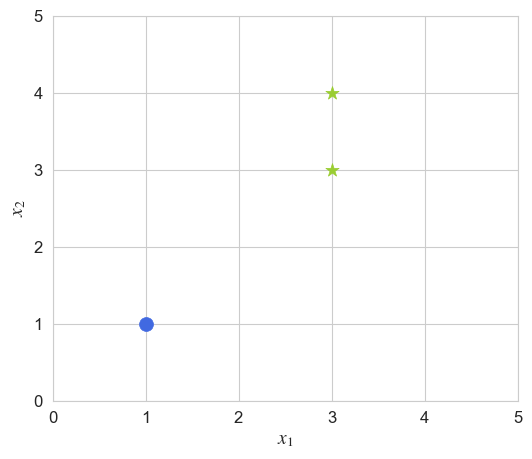

In [5]:
X = np.array([[3,3],[3,4],[1,1]]).astype(np.float64)
y = np.array([1,1,-1])
# 绘制数据图像
fig_path = os.path.normpath('image/examples/')
draw_class2(fig_path,fig_name='linear_svm_ex1.pdf',data=(X,y),xlim=[0,5],ylim=[0,5])

     pcost       dcost       gap    pres   dres
 0: -2.6873e-01 -6.7301e-01  4e+00  2e+00  1e+00
 1: -1.4232e-01 -5.9278e-01  5e-01  2e-16  3e-16
 2: -2.3773e-01 -2.7513e-01  4e-02  1e-16  5e-16
 3: -2.4959e-01 -2.5037e-01  8e-04  6e-17  6e-16
 4: -2.5000e-01 -2.5000e-01  8e-06  6e-17  3e-16
 5: -2.5000e-01 -2.5000e-01  8e-08  6e-17  4e-16
Optimal solution found.

对3个训练样本分类的正确率：100.0%
支持向量个数：2
sv-0: [3. 3.] d-0: 1  a-0: 0.250000
sv-2: [1. 1.] d-2: -1  a-2: 0.250000
weights: [0.49999975 0.49999975]
bias: -1.9999990041223819


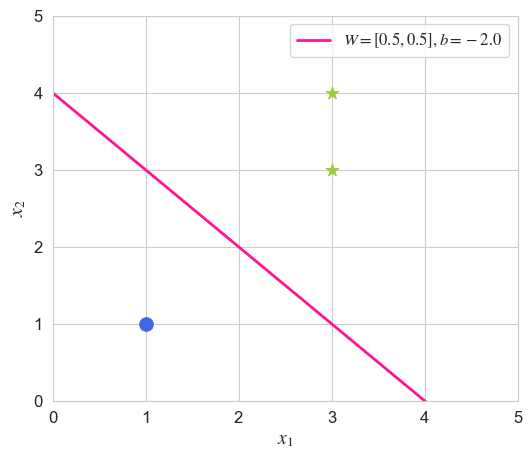

In [6]:
# 利用 线性SVM 解决线性可分问题
sample_num,input_size = X.shape

# 构建linear_svm模型
# 线性核函数
kernel = [linear_kernel,None]

model = kernel_svm(input_size,sample_num,kernel=kernel)

# 实例化Runner类
runner = Runner(model)

# 训练SVM
train_dataset = (X,y)
runner.train(train_dataset)

print('\n对3个训练样本分类的正确率：{}%'.format(runner.train_score*100))
print('支持向量个数：{}'.format(model.support_num))

for i,idx in enumerate(model.support_id):
    print('sv-{}: {} d-{}: {}  a-{}: {:2f}'.format(idx,model.support_vectors[i],idx,model.support_tags[i],idx,model.support_alphas[i]))
    
print('weights:',model.param['weights'])
print('bias:',model.param['bias'])
weights = model.param['weights']
bias = model.param['bias']
draw_class2(fig_path,fig_name='linear_svm_ex1_c2.pdf',data=(X,y),weights=weights,bias=bias,xlim=[0,5],ylim=[0,5])


## 非线性SVM解决XOR问题

<font size=4 color=blue> **XOR问题：** </font> <font size=4 face="宋体"> 4个训练样本如图所示, 其正样本是 $ \boldsymbol{X}^1=(-1,-1)^T, \boldsymbol{X}^2=(1,1)^T$ , 负样本是  $\boldsymbol{X}^3=(-1,1)^T, \boldsymbol{X}^4=(1,-1)^T$.</font>

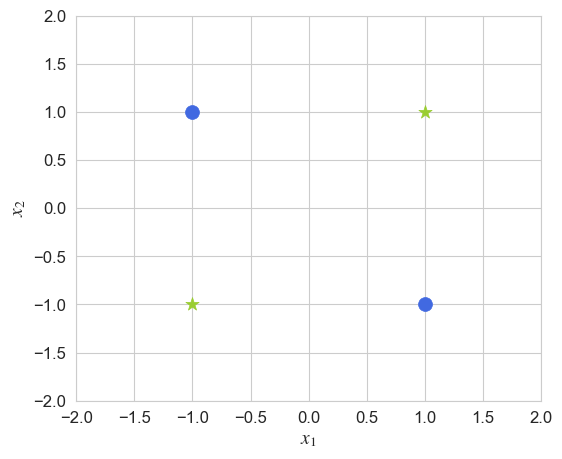

In [7]:
X = np.array([[-1,-1],[1,1],[-1,1],[1,-1]]).astype(np.float64)
y = np.array([1,1,-1,-1])
# 绘制数据图像
fig_path = os.path.normpath('image/examples/')
draw_class2(fig_path,fig_name='xor.pdf',data=(X,y),xlim=[-2,2],ylim=[-2,2])

<font size=4 color=blue> **方法：** </font>   <font size=4 face="宋体"> 选择（二次）多项式核函数 $\kappa(\boldsymbol{X},\boldsymbol{X}^p)$ 求解XOR问题</font>

In [8]:
# 利用 核SVM 解决XOR问题
sample_num,input_size = X.shape

# 构建kernel_svm模型
kernel = [polynomial_kernel,2]
# kernel = [gauss_kernel,0.5]
#kernel = [laplace_kernel,0.5]

model = kernel_svm(input_size,sample_num,kernel=kernel)

# 实例化Runner类
runner = Runner(model)

# 训练SVM
train_dataset = (X,y)
runner.train(train_dataset)

print('\n对4个训练样本分类的正确率：{}%'.format(runner.train_score*100))
print('支持向量个数：{}'.format(model.support_num))
for i,idx in enumerate(model.support_id):
    print('sv-{}: {} d-{}: {}  a-{}: {:2f}'.format(idx,model.support_vectors[i],idx,model.support_tags[i],idx,model.support_alphas[i]))
    
print('bias:',model.param['bias'])

     pcost       dcost       gap    pres   dres
 0: -2.4691e-01 -6.9136e-01  4e-01  3e-17  1e+00
 1: -2.4973e-01 -2.5457e-01  5e-03  6e-17  4e-02
 2: -2.5000e-01 -2.5005e-01  5e-05  6e-17  4e-04
 3: -2.5000e-01 -2.5000e-01  5e-07  3e-17  4e-06
 4: -2.5000e-01 -2.5000e-01  5e-09  7e-17  4e-08
Optimal solution found.

对4个训练样本分类的正确率：100.0%
支持向量个数：4
sv-0: [-1. -1.] d-0: 1  a-0: 0.125000
sv-1: [1. 1.] d-1: 1  a-1: 0.125000
sv-2: [-1.  1.] d-2: -1  a-2: 0.125000
sv-3: [ 1. -1.] d-3: -1  a-3: 0.125000
bias: 0.0
